In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(lsmeans))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(export))
suppressPackageStartupMessages(library(ggtext))
R.Version()
getwd()

Warning message in rgl.init(initValue, onlyNULL):
“RGL: unable to open X11 display”
Warning message:
“'rgl.init' failed, running with 'rgl.useNULL = TRUE'.”


$platform
[1] "x86_64-apple-darwin17.0"

$arch
[1] "x86_64"

$os
[1] "darwin17.0"

$system
[1] "x86_64, darwin17.0"

$status
[1] ""

$major
[1] "4"

$minor
[1] "0.2"

$year
[1] "2020"

$month
[1] "06"

$day
[1] "22"

$`svn rev`
[1] "78730"

$language
[1] "R"

$version.string
[1] "R version 4.0.2 (2020-06-22)"

$nickname
[1] "Taking Off Again"

[1] "/Users/yangzhang/Box/Zhang_Projects/MANUSCRIPT_PPAR/github_repo/PPAR/manuscript/figures/figure02"

# Import data

## - Promethion

In [2]:
profile <- read.csv(file = "/Users/yangzhang/Box/Zhang_Projects/MANUSCRIPT_PPAR/github_repo/PPAR/data/process/fig2_stat_corrected.csv", as.is = TRUE)
profile$Diet <- as.factor(profile$Diet)
profile$Diet <- factor(profile$Diet, levels = c("HFD", "HFD+LXN", "HFD+HXN", "HFD+TXN", "LFD"))
profile$MouseID <- ordered(profile$MouseID)
profile$MouseID <- as.factor(profile$MouseID); head(profile)

,Time,Diet,Cycle,MouseID,EE,VO2,VCO2,VH2O,RER
,<chr>,<fct>,<chr>,<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Cycle1:06:00-07:00,LFD,light,1,0.5404855,1.817773,1.667495,0.07543786,0.9165888
2,Cycle1:07:00-08:00,LFD,light,1,0.4461322,1.506156,1.356034,0.09581117,0.8918554
3,Cycle1:08:00-09:00,LFD,light,1,0.3800183,1.302917,1.083944,0.06242484,0.8325571
4,Cycle1:09:00-10:00,LFD,light,1,0.5073735,1.732713,1.471611,0.07426177,0.8477622
5,Cycle1:10:00-11:00,LFD,light,1,0.4239801,1.468392,1.156785,0.08923397,0.7837234
6,Cycle1:11:00-12:00,LFD,light,1,0.3796648,1.319942,1.017954,0.07234710,0.7704386


## - Phenotypes

In [3]:
data <- read.csv("/Users/yangzhang/Box/Zhang_Projects/MANUSCRIPT_PPAR/github_repo/PPAR/data/process/fig2_table3.csv", header = T); 
data$vars <- factor(data$Treatment, levels = c("LFD", "HFD", "HFD+LXN", "HFD+HXN", "HFD+TXN"))
data$vars2 <- factor(data$Treatment, levels = c("HFD", "HFD+LXN", "HFD+HXN", "HFD+TXN", "LFD"))
data <- data %>% mutate(lv_tot_tag = (LV_TAG * liver_wt)/1000,
                        EE_norm = avgEE*1000/Lean_mass, 
                        fecal_tot_tag = TG_feces2*fecal_tot_output, 
                        kkcal = Cal_cum/1000,
                        uptake_f = uptake_freq_light + uptake_freq_dark,
                        allMeters = allmeters_light+allmeters_dark,
                        allPeds = pedmeters_light+pedmeters_dark); head(data)
txn <- data %>% filter(vars2 == "HFD+TXN"); hfd <- data %>% filter(vars2 == "HFD");
lxn <- data %>% filter(vars2 == "HFD+LXN"); hxn <- data %>% filter(vars2 == "HFD+HXN");
lfd <- data %>% filter(vars2 == "LFD")

,ID,Treatment,Cal_cum,LV_TAG,lipidosis_area_pct,Fat_mass,subq_wt,epi_wat,mesenteric_wt,plasma_TAG,⋯,bw_cage,vars,vars2,lv_tot_tag,EE_norm,fecal_tot_tag,kkcal,uptake_f,allMeters,allPeds
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,1,LFD,1425.870,367.77,17.596,11.152,0.40,1.80,0.33,38.547,⋯,35.1,LFD,LFD,0.5810766,22.21568,17.55000,1.425870,23,227.4935,190.1555
2,2,LFD,1241.231,400.53,0.696,7.357,0.72,1.34,0.48,53.408,⋯,28.9,LFD,LFD,0.5126784,21.79943,15.02280,1.241231,26,267.6345,227.4692
3,3,LFD,1298.180,379.47,17.311,10.517,0.89,2.08,0.94,68.087,⋯,32.2,LFD,LFD,0.5236686,28.79635,13.38480,1.298180,23,251.1943,212.1898
4,4,LFD,1812.026,332.67,16.353,12.781,0.78,2.13,0.54,37.492,⋯,35.7,LFD,LFD,0.6520332,30.11525,20.70900,1.812026,34,295.1175,237.1283
5,5,LFD,1373.638,408.33,5.164,6.385,0.26,0.97,0.32,46.053,⋯,30.0,LFD,LFD,0.5634954,22.49855,17.52855,1.373638,29,262.2310,231.9523
6,6,LFD,1448.174,454.35,22.362,11.460,0.99,2.07,0.60,45.932,⋯,38.4,LFD,LFD,0.7224165,25.35729,7.85460,1.448174,50,234.2913,177.0421


# Set theme, import functions

In [4]:
theme_set(theme_bw())

In [5]:
theme_legend2 = function(){
	theme(axis.title.y = element_text(size = 15, 
	margin = margin(t=0, r=5, b=0, l=5)),
	axis.text.y = element_text(size = 13),
	axis.text.x = element_text(size = 13),
	axis.title.x = element_text(size = 15,
                               margin = margin(t=10, r=5, b=0, l=0)),
    plot.title = element_text(size = 15, face = "bold"),
	legend.title = element_text(colour = "white"),
	legend.text = element_text(size = 16),
	legend.position = "none",
	plot.margin = unit(c(0.5,0.5,0,0.5), "cm"),
	panel.grid = element_blank())
}

In [6]:
source("/Users/yangzhang/Box/Zhang_Projects/MANUSCRIPT_PPAR/github_repo/PPAR/manuscript/figures/src/ggplotRegression.R")

In [7]:
mycolor <- c("#0080ff", "#ffa500", "red", "darkgreen", "black")
mycolor_alpha <- c("#8AB5F9", "#F8CB89", "#F08581", "#87A57E", "#797979")

In [8]:
Contrasts <- list(
    'LFD vs HFD' = c(-1, 0, 0, 0, 1),
    'LXN vs HFD' = c(-1, 1, 0, 0, 0),
    'HXN vs HFD' = c(-1, 0, 1, 0, 0),
    'TXN vs HFD' = c(-1, 0, 0, 1, 0))

# Figures

## - A. fat mass boxplot

In [9]:
names(data)

[1] "ID"                 "Treatment"          "Cal_cum"           
 [4] "LV_TAG"             "lipidosis_area_pct" "Fat_mass"          
 [7] "subq_wt"            "epi_wat"            "mesenteric_wt"     
[10] "plasma_TAG"         "liver_wt"           "TG_feces"          
[13] "TG_feces2"          "fecal_tot_output"   "wt"                
[16] "Lean_mass"          "Lean_mass_outlier"  "avgEE"             
[19] "avgEE2"             "leptin_new"         "glucose_plasma"    
[22] "insulin_plasma"     "CHL_feces2"         "uptake_freq_light" 
[25] "uptake_freq_dark"   "allmeters_light"    "allmeters_dark"    
[28] "pedmeters_light"    "pedmeters_dark"     "bw_cage"           
[31] "vars"               "vars2"              "lv_tot_tag"        
[34] "EE_norm"            "fecal_tot_tag"      "kkcal"             
[37] "uptake_f"           "allMeters"          "allPeds"

In [90]:
data3 <- data %>%
filter(Treatment == "HFD" | Treatment == 'HFD+TXN' | Treatment == 'HFD+HXN' | Treatment == 'HFD+LXN')

In [91]:
fit <- lm(avgEE2~bw_cage+Treatment, data3)
anova(fit)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
bw_cage,1,0.087657533,0.087657533,84.204440,2.169040e-11
Treatment,3,0.005186546,0.001728849,1.660744,1.907999e-01
Residuals,40,0.041640338,0.001041008,NA,NA


In [73]:
fit <- lm(avgEE2~Treatment+bw_cage, data3)
anova(fit)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Treatment,2,0.02985029,0.0149251469,21.12812,2.181919e-06
bw_cage,1,0.03839729,0.0383972896,54.35542,4.016775e-08
Residuals,29,0.02048593,0.0007064115,NA,NA


In [19]:
theme_legend1 = function(){
	theme(axis.title.y = element_text(size = 15, 
	margin = margin(t=0, r=5, b=0, l=5)),
	axis.text.y = element_text(size = 13),
	axis.text.x = element_text(size = 13),
	axis.title.x = element_text(size = 15,
                               margin = margin(t=10, r=5, b=0, l=0)),
    #plot.title = element_text(size = 15, face = "bold"),
          plot.title = element_markdown(),
	legend.title = element_text(colour = "white"),
	legend.text = element_text(size = 16),
	legend.position = c(0.8, 0.2),
	plot.margin = unit(c(0.5,0.5,0,0.5), "cm"),
	panel.grid = element_blank())
}

In [52]:
subq <- ggplot(dataF,aes(y = avgEE2, x = subq_wt, colour = Treatment, shape = Treatment)) +
   geom_point(size=3) + geom_smooth(method = "lm", fill = NA) + ylab('energy expenditure') + xlab('subq') + theme_legend1()

In [53]:
lvTAG <- ggplot(dataF,aes(y = avgEE2, x = LV_TAG, colour = Treatment, shape = Treatment)) +
   geom_point(size=3) + geom_smooth(method = "lm", fill = NA) + ylab('energy expenditure') + xlab('lv tag') + theme_legend1()

In [57]:
lipidpct <- ggplot(dataF,aes(y = avgEE2, x = lipidosis_area_pct, colour = Treatment, shape = Treatment)) +
   geom_point(size=3) + geom_smooth(method = "lm", fill = NA) + ylab('energy expenditure') + xlab('lipid percent area') + theme_legend1()

In [62]:
calorie <- ggplot(dataF,aes(y = avgEE2, x = Cal_cum, colour = Treatment, shape = Treatment)) +
   geom_point(size=3) + geom_smooth(method = "lm", fill = NA) + ylab('energy expenditure') + xlab('caloric intake') + theme_legend1()

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



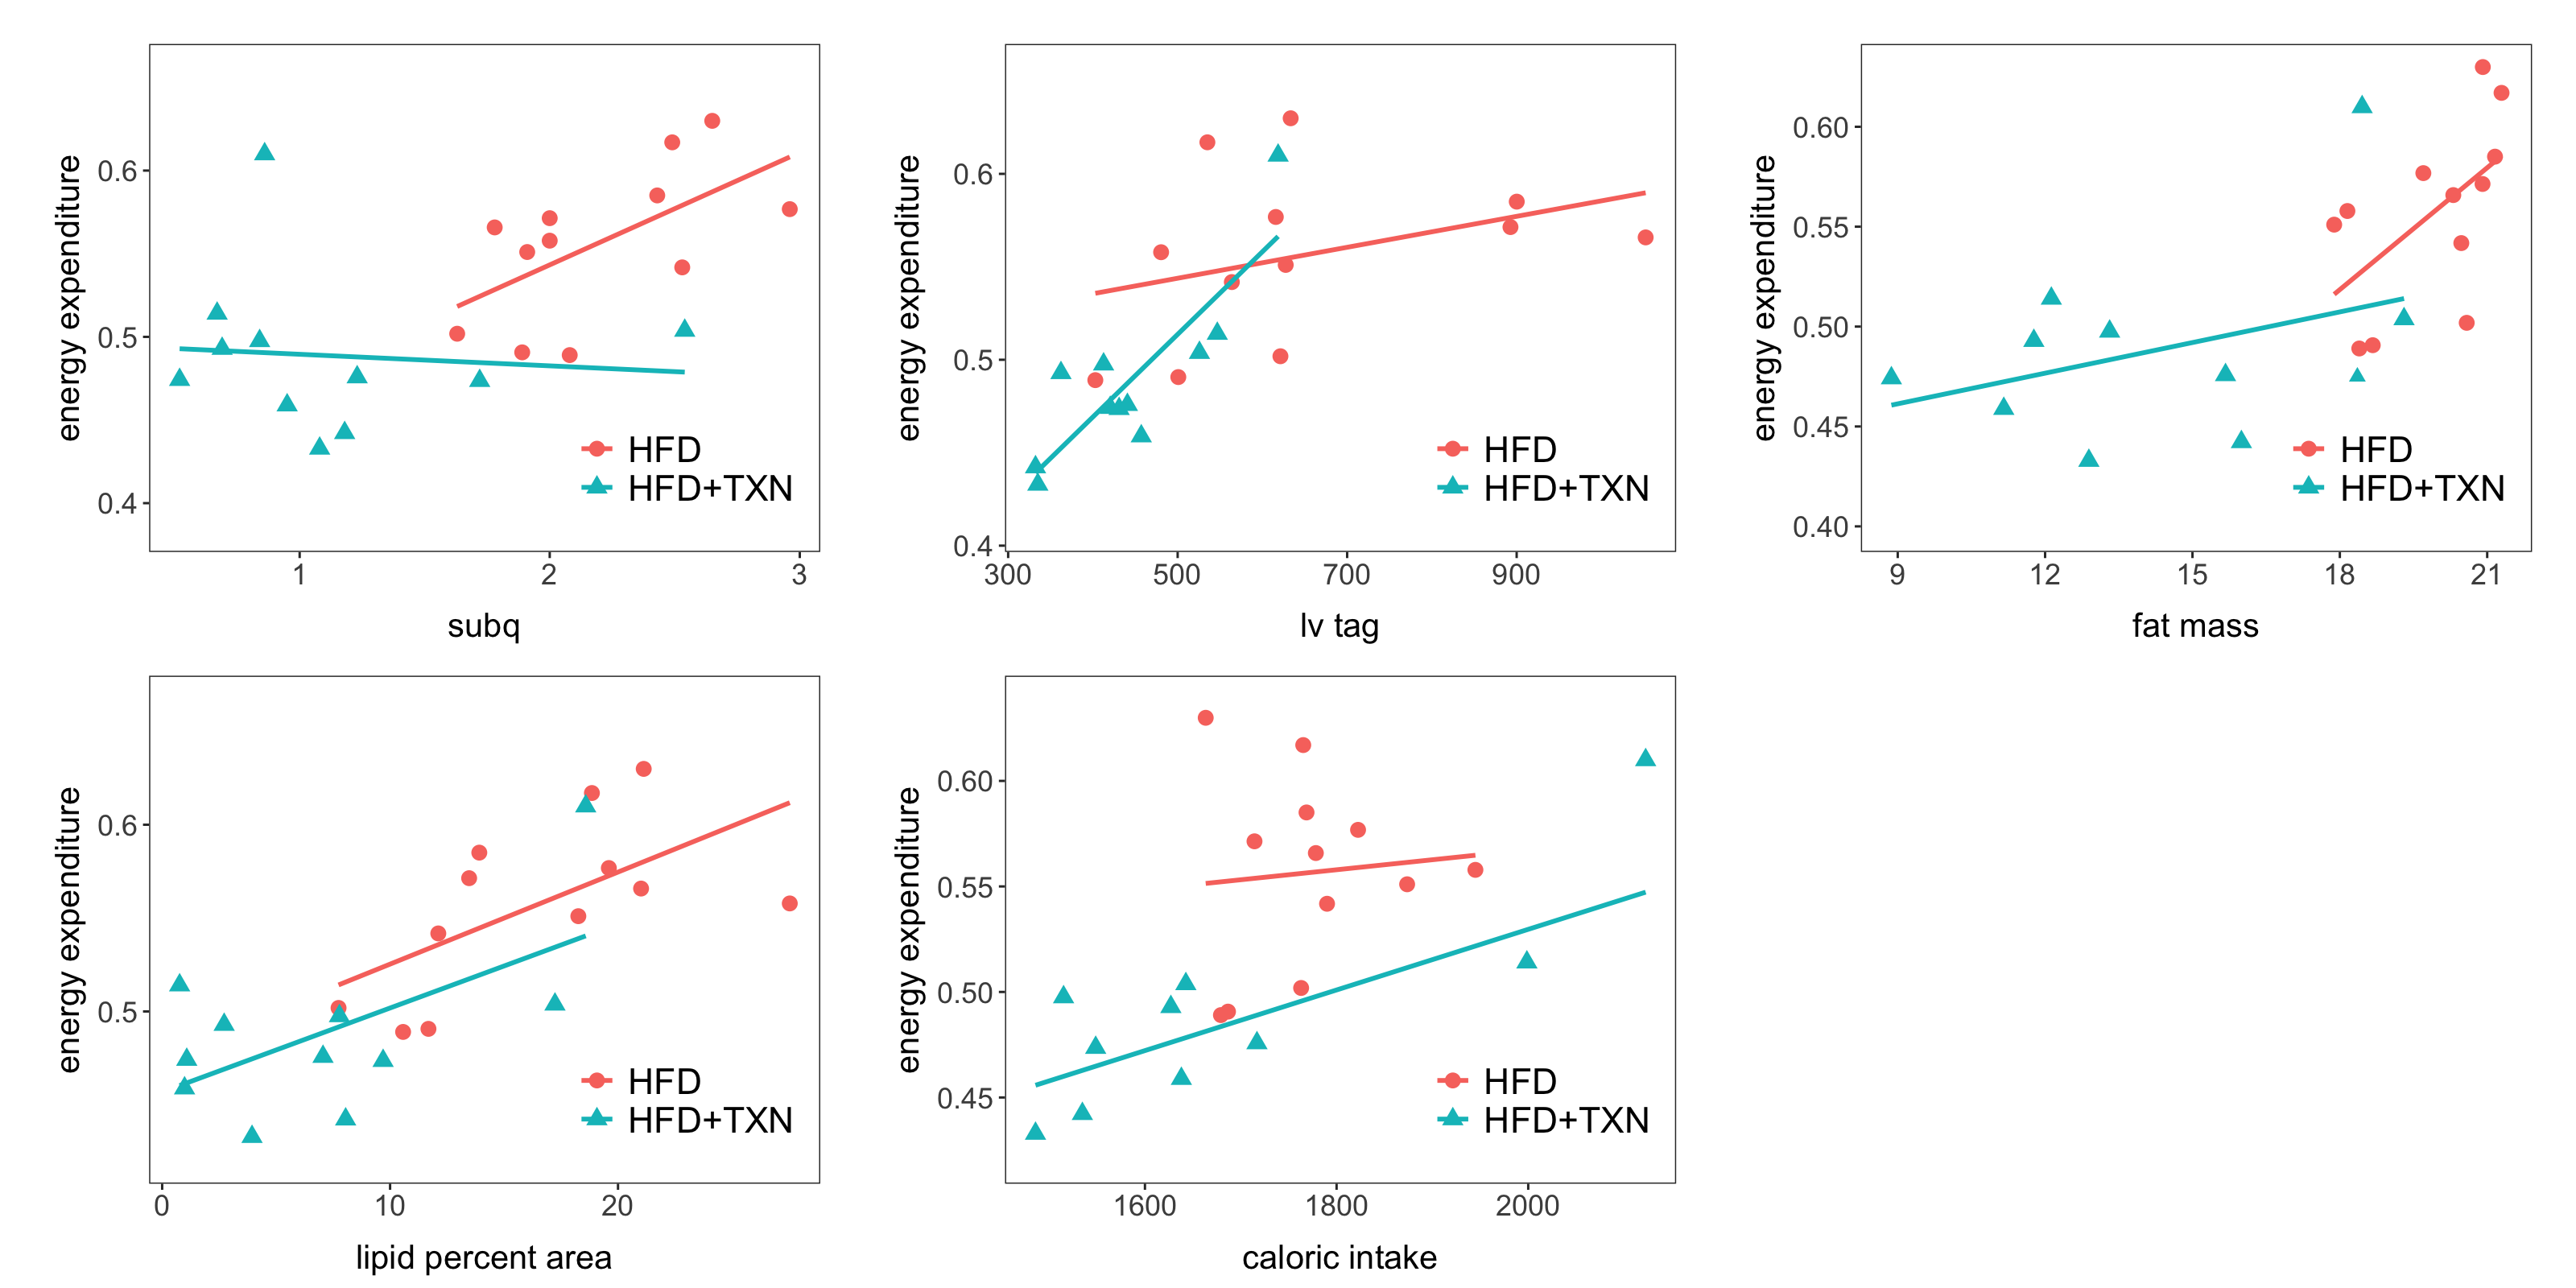

In [63]:
options(repr.plot.width = 16, repr.plot.height = 8, repr.plot.res = 200)
(subq| lvTAG | parD | lipidpct | calorie) + plot_layout(nrow = 2, ncol=3)

In [252]:
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 200)
parA <- ggplot(dataF,aes(y = avgEE2, x = Lean_mass, colour = Treatment, shape = Treatment)) +
   geom_point(size=3) + geom_smooth(method = "lm", fill = NA) + ylab('energy expenditure') + xlab('lean mass') + theme_legend1()
parB <- ggplot(dataF,aes(y = avgEE2, x = Lean_mass_outlier, colour = Treatment, shape = Treatment)) +
   geom_point(size=3) + geom_smooth(method = "lm", fill = NA) + ylab('energy expenditure') + xlab('lean mass - outlier') + theme_legend1()

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


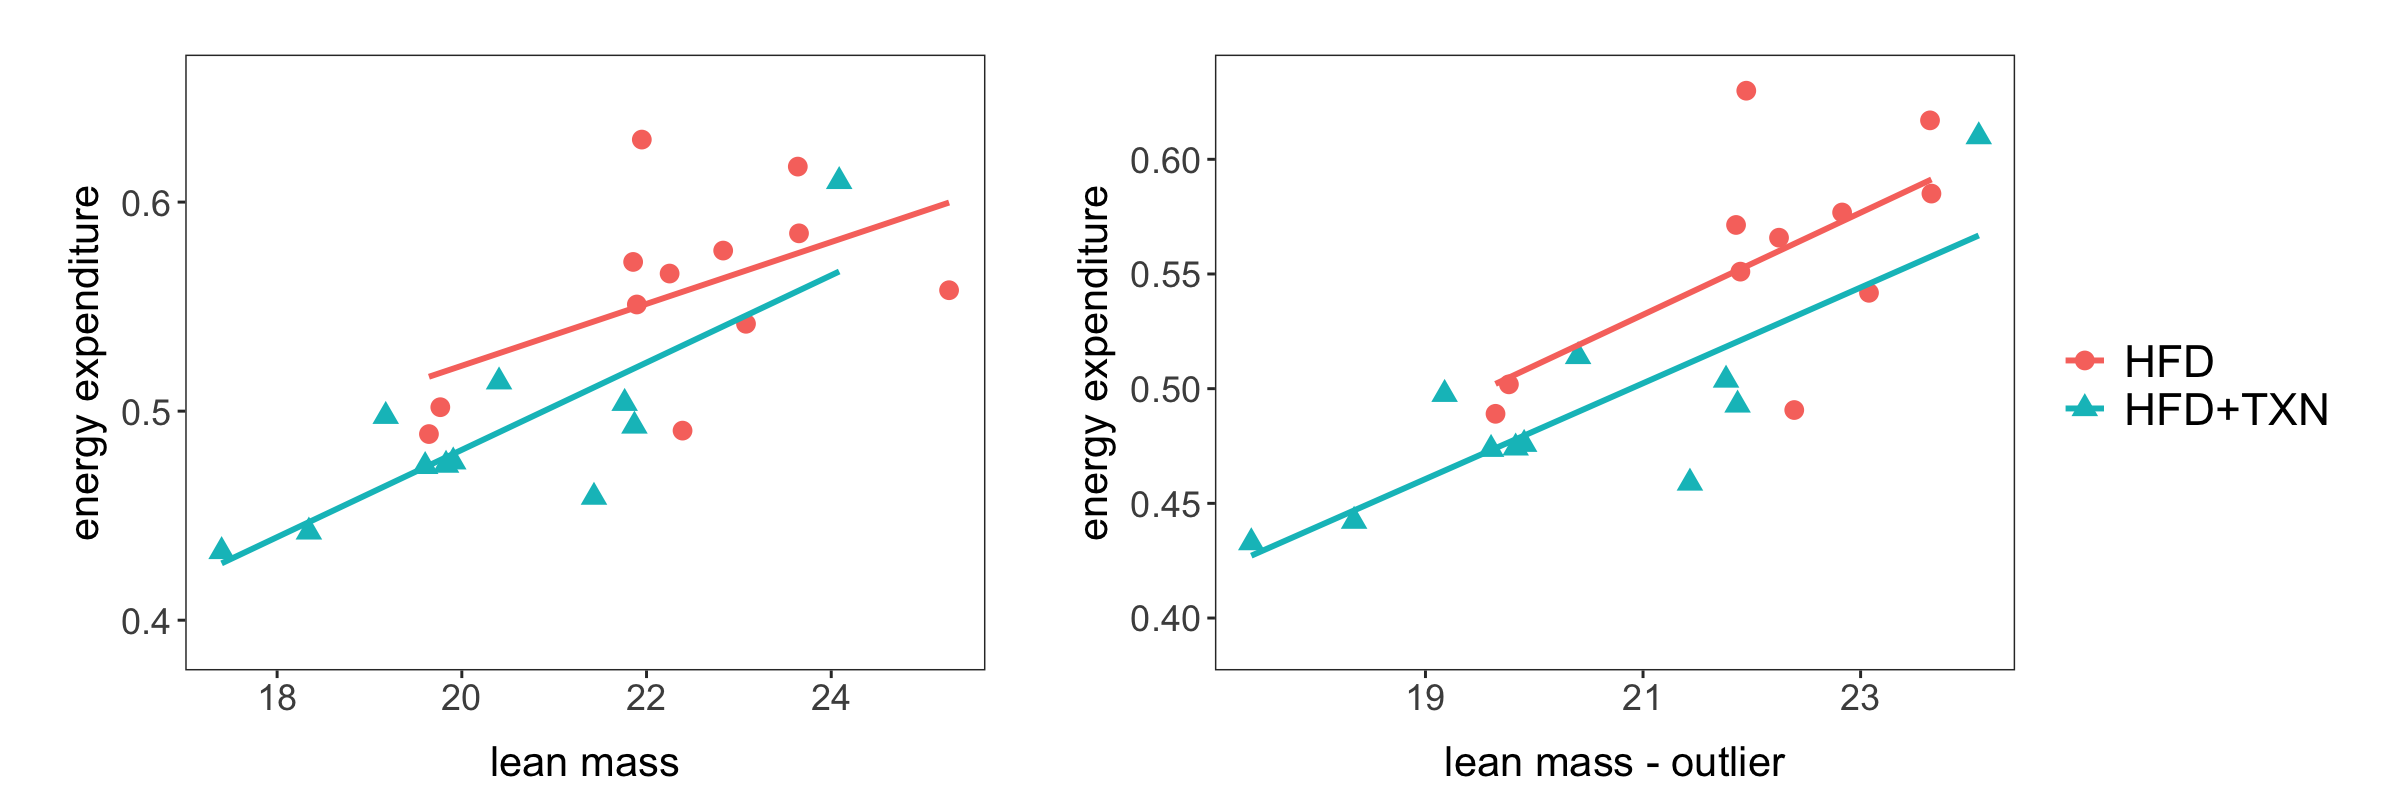

In [253]:
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 200)
(parA | parB) + plot_layout(nrow = 1, ncol=2, guides = "collect")

In [258]:
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 200)
parC <- ggplot(dataF,aes(y = avgEE2, x = Fat_mass, colour = Treatment, shape = Treatment)) +
   geom_point(size=3) + geom_smooth(method = "lm", fill = NA) + ylab('energy expenditure') + xlab('fat mass') + theme_legend1()
parD <- ggplot(dataF,aes(y = avgEE2, x = wt, colour = Treatment, shape = Treatment)) +
   geom_point(size=3) + geom_smooth(method = "lm", fill = NA) + ylab('energy expenditure') + xlab('total body mass') + theme_legend1()

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



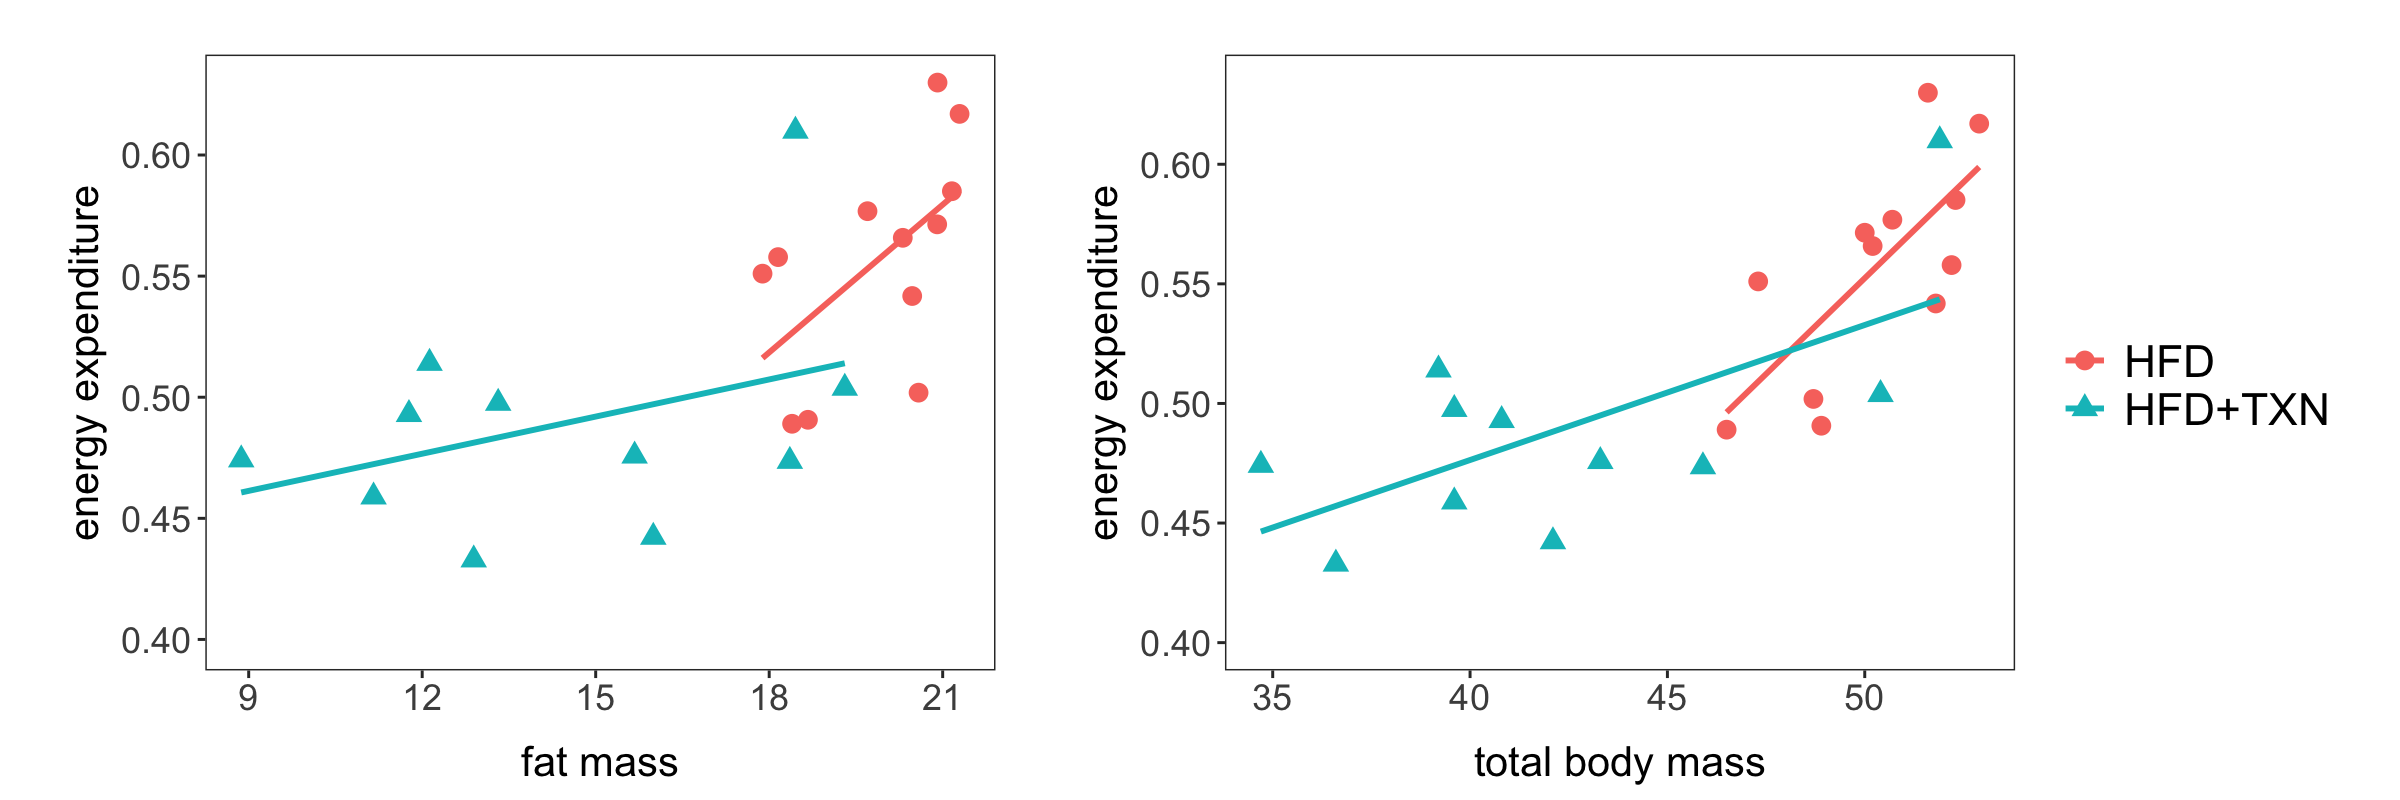

In [259]:
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 200)
(parC | parD) + plot_layout(nrow = 1, ncol=2, guides = "collect")

In [205]:
library(psych)
# Summarizing data
data_new <- dataF %>% 
  group_by(Treatment, Lean_mass, avgEE2) %>% 
  summarise(y_mean = mean(avgEE2)#,
            #y_se = psych::describe(Lean_mass)$se
           )

head(data_new)

`summarise()` regrouping output by 'Treatment', 'Lean_mass' (override with `.groups` argument)



Treatment,Lean_mass,avgEE2,y_mean
<chr>,<dbl>,<dbl>,<dbl>
HFD,19.644,0.4890386,0.4890386
HFD,19.767,0.5018868,0.5018868
HFD,21.855,0.5713762,0.5713762
HFD,21.895,0.5510202,0.5510202
HFD,21.949,0.6299049,0.6299049
HFD,22.250,0.5658187,0.5658187


In [161]:
library(broom)
library(rstatix)


Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter




In [163]:
model <- lm(avgEE2 ~ Lean_mass + Treatment, data)

In [164]:
#augment(model)

In [166]:
res.aov <- data %>% anova_test(avgEE2 ~ Lean_mass + Treatment)
get_anova_table(res.aov)

Warning message:
“NA detected in rows: 45,48.
Removing this rows before the analysis.”
Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Lean_mass,1,51,29.362,1.64e-06,*,0.365
2,Treatment,4,51,1.136,3.50e-01,,0.082


In [155]:
model


Call:
lm(formula = avgEE2 ~ Treatment + Lean_mass, data = data)

Coefficients:
     (Intercept)  TreatmentHFD+HXN  TreatmentHFD+LXN  TreatmentHFD+TXN  
        0.120492         -0.035857         -0.007017         -0.028679  
    TreatmentLFD         Lean_mass  
       -0.019328          0.019507  


In [119]:
data2 <- data %>%
filter(Treatment != "LFD")

In [153]:
fit <- aov(avgEE2 ~ wt+Treatment, data2)
anova(fit)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
wt,1,0.05930817,0.059308167,36.295181,4.365332e-07
Treatment,3,0.00981422,0.003271407,2.002023,1.291428e-01
Residuals,40,0.06536203,0.001634051,NA,NA


In [138]:
fit <- aov(avgEE2~Treatment*wt*Fat_mass*Lean_mass, data2)
anova(fit)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Treatment,3,4.454772e-02,1.484924e-02,10.856647869,0.0007589266
wt,1,2.457467e-02,2.457467e-02,17.967152926,0.0009671824
Fat_mass,1,9.665007e-03,9.665007e-03,7.066326756,0.0196998358
Lean_mass,1,2.772827e-03,2.772827e-03,2.027282489,0.1780541034
Treatment:wt,3,2.451933e-03,8.173108e-04,0.597556286,0.6277964873
Treatment:Fat_mass,3,4.887623e-03,1.629208e-03,1.191154275,0.3515127000
wt:Fat_mass,1,1.193880e-04,1.193880e-04,0.087287514,0.7723202897
Treatment:Lean_mass,3,6.604937e-04,2.201646e-04,0.160967794,0.9206959261
wt:Lean_mass,1,2.419183e-03,2.419183e-03,1.768724707,0.2064032375


In [121]:
fit <- aov(avgEE2~Treatment*wt*uptake_f, data2)
anova(fit)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Treatment,3,0.0445477167,0.0148492389,9.8870662,0.0001182611
wt,1,0.0245746707,0.0245746707,16.3625487,0.0003539370
uptake_f,1,0.0020611182,0.0020611182,1.3723540,0.2509432285
Treatment:wt,3,0.0048464342,0.0016154781,1.0756335,0.3747946549
Treatment:uptake_f,3,0.0066697357,0.0022232452,1.4803030,0.2405186642
wt:uptake_f,1,0.0004289362,0.0004289362,0.2855985,0.5971286788
Treatment:wt:uptake_f,3,0.0078011327,0.0026003776,1.7314090,0.1824832254
Residuals,29,0.0435546724,0.0015018853,NA,NA


In [122]:
fit <- aov(avgEE2~Treatment*wt*uptake_f, data)
anova(fit)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Treatment,4,0.0473559169,0.0118389792,7.4718846,1.620902e-04
wt,1,0.0474014372,0.0474014372,29.9162673,3.282816e-06
uptake_f,1,0.0004195819,0.0004195819,0.2648089,6.098959e-01
Treatment:wt,4,0.0140158856,0.0035039714,2.2114466,8.660885e-02
Treatment:uptake_f,4,0.0072409627,0.0018102407,1.1424895,3.517984e-01
wt:uptake_f,1,0.0029244480,0.0029244480,1.8456944,1.825106e-01
Treatment:wt:uptake_f,4,0.0172746355,0.0043186589,2.7256168,4.385251e-02
Residuals,37,0.0586254013,0.0015844703,NA,NA


In [ ]:
fit <- aov(avgEE2~Treatment*Lean_mass*uptake_f, data2)
anova(fit)

In [95]:
fit1 <- aov(avgEE2~Treatment*Lean_mass, data)
fit2 <- aov(avgEE2~Treatment+Lean_mass, data)
anova(fit1, fit2)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,47,0.08806912,NA,NA,NA,NA
2,51,0.09386349,-4,-0.005794365,0.7730721,0.548244


In [117]:
fit <- aov(avgEE2~Treatment*Lean_mass*uptake_f, data)

In [118]:
anova(fit)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Treatment,4,0.0473559169,0.0118389792,8.409755,6.252728e-05
Lean_mass,1,0.0540388646,0.0540388646,38.386217,3.412915e-07
uptake_f,1,0.0006478813,0.0006478813,0.460219,5.017428e-01
Treatment:Lean_mass,4,0.0067679575,0.0016919894,1.201896,3.263570e-01
Treatment:uptake_f,4,0.0083803126,0.0020950782,1.488227,2.255796e-01
Lean_mass:uptake_f,1,0.0019071633,0.0019071633,1.354743,2.519014e-01
Treatment:Lean_mass:uptake_f,4,0.0240727792,0.0060181948,4.274992,6.069025e-03
Residuals,37,0.0520873939,0.0014077674,NA,NA


In [94]:
model <- lm(Lean_mass ~ vars2, data = data)
leastsquare <- lsmeans(model, "vars2")
contrast(leastsquare, Contrasts, adjust = "none")

 contrast   estimate    SE df t.ratio p.value
 LFD vs HFD   -1.342 0.663 54 -2.023  0.0480 
 LXN vs HFD    0.446 0.663 54  0.672  0.5042 
 HXN vs HFD   -1.049 0.663 54 -1.581  0.1196 
 TXN vs HFD   -2.005 0.678 54 -2.957  0.0046 


In [9]:
A <- ggplot(data = data, aes(x = vars2, y = Lean_mass, fill = vars2)) +
	stat_boxplot(geom = 'errorbar', linetype = 1, width = 0.2) +
	geom_boxplot(outlier.shape = NA) +
	scale_fill_manual(values = mycolor_alpha) +
	geom_jitter(shape = 20, size = 3, width = 0.2, height = 0.1) +
    labs(x="",y="g",title="A. Lean mass") +
	theme_legend2()

label.df <- data.frame(vars2 = c("HFD+TXN", "LFD"),
                       Lean_mass = c(24.1, 22.9))
A <- A + geom_text(data = label.df, label = c("**", "*"), color='red', size = 8)

## - B. average energy expenditure

In [11]:
model <- lm(avgEE2 ~ vars2, data = data)
leastsquare <- lsmeans(model, "vars2")
contrast(leastsquare, Contrasts, adjust = "none")

 contrast   estimate     SE df t.ratio p.value
 LFD vs HFD -0.04550 0.0218 52 -2.090  0.0415 
 LXN vs HFD  0.00168 0.0218 52  0.077  0.9387 
 HXN vs HFD -0.05473 0.0228 52 -2.397  0.0202 
 TXN vs HFD -0.06780 0.0223 52 -3.046  0.0036 


In [84]:
C <- ggplot(data = data, aes(x = vars2, y = avgEE2, fill = vars2)) +
	stat_boxplot(geom = 'errorbar', linetype = 1, width = 0.2) +
	geom_boxplot(outlier.shape = NA) +
	scale_fill_manual(values = mycolor_alpha) +
	geom_jitter(shape = 20, size = 3, width = 0.2, height = 0.1) +
    labs(x="",y="kcal/hr",title="B. Average energy expenditure") +
	theme_legend2()

label.df <- data.frame(vars2 = c("HFD+HXN", "HFD+TXN", "LFD"),
                       avgEE2 = c(0.6, 0.55, 0.58))
C <- C + geom_text(data = label.df, label = c("*", "**", "*"), color='red', size = 8)

In [85]:
options(repr.plot.width = 20, repr.plot.height = 4, repr.plot.res = 150)
row1 <- (A | C) + plot_layout(nrow = 1, ncol=2)

In [86]:
lfd_Fat_mass_cal <- ggplotRegression(lm(Lean_mass ~ kkcal, data = lfd), "black") + 
                        labs(title = "A-1 LFD", x = "1000 kcal", y = "lean mass (g)")+ theme_legend2()
hfd_Fat_mass_cal <- ggplotRegression(lm(Lean_mass ~ kkcal, data = hfd), "#0080ff")+ 
                        labs(title = "A-2 HFD", x = "1000 kcal", y = "lean mass (g)")+ theme_legend2()
lxn_Fat_mass_cal <- ggplotRegression(lm(Lean_mass ~ kkcal, data = lxn), "#ffa500")+ 
                        labs(title = "A-3 HFD+LXN", x = "1000 kcal", y = "lean mass (g)")+ theme_legend2()
hxn_Fat_mass_cal <- ggplotRegression(lm(Lean_mass ~ kkcal, data = hxn), "red")+ ggtitle("HXN")+ 
                        labs(title = "A-4 HFD+HXN", x = "1000 kcal", y = "lean mass (g)")+ theme_legend2()
txn_Fat_mass_cal <- ggplotRegression(lm(Lean_mass ~ kkcal, data = txn), "darkgreen")+ 
                        labs(title = "A-5 HFD+TXN", x = "1000 kcal", y = "lean mass (g)")+ theme_legend2()

In [87]:
lfd_EE_cal <- ggplotRegression(lm(avgEE ~ Lean_mass, data = lfd), "black") + 
                        labs(title = "B-1 LFD", x = "lean mass", y = "energy expenditure")+ theme_legend2()
hfd_EE_cal <- ggplotRegression(lm(avgEE ~ Lean_mass, data = hfd), "#0080ff")+ 
                        labs(title = "B-2 HFD", x = "lean mass", y = "energy expenditure")+ theme_legend2()
lxn_EE_cal <- ggplotRegression(lm(avgEE ~ Lean_mass, data = lxn), "#ffa500")+ 
                        labs(title = "B-3 HFD+LXN", x = "lean mass", y = "energy expenditure")+ theme_legend2()
hxn_EE_cal <- ggplotRegression(lm(avgEE2 ~ Lean_mass, data = hxn), "red")+ ggtitle("HXN")+ 
                        labs(title = "B-4 HFD+HXN", x = "lean mass", y = "energy expenditure")+ theme_legend2()
txn_EE_cal <- ggplotRegression(lm(avgEE ~ Lean_mass, data = txn), "darkgreen")+ 
                        labs(title = "B-5 HFD+TXN", x = "lean mass", y = "energy expenditure")+ theme_legend2()

In [88]:
options(repr.plot.width = 20, repr.plot.height = 4, repr.plot.res = 150)
row2 <- (lfd_Fat_mass_cal | lfd_EE_cal) + plot_layout(nrow = 1, ncol = 2)

In [89]:
options(repr.plot.width = 20, repr.plot.height = 4, repr.plot.res = 150)
row3 <- (hfd_Fat_mass_cal | hfd_EE_cal) + plot_layout(nrow = 1, ncol = 2)

In [90]:
options(repr.plot.width = 20, repr.plot.height = 4, repr.plot.res = 150)
row4 <- (lxn_Fat_mass_cal | lxn_EE_cal) + plot_layout(nrow = 1, ncol = 2)

In [91]:
options(repr.plot.width = 20, repr.plot.height = 4, repr.plot.res = 150)
row5 <- (hxn_Fat_mass_cal | hxn_EE_cal) + plot_layout(nrow = 1, ncol = 2)

In [92]:
options(repr.plot.width = 20, repr.plot.height = 4, repr.plot.res = 150)
row6 <- (txn_Fat_mass_cal | txn_EE_cal) + plot_layout(nrow = 1, ncol = 2)

## Put together

Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



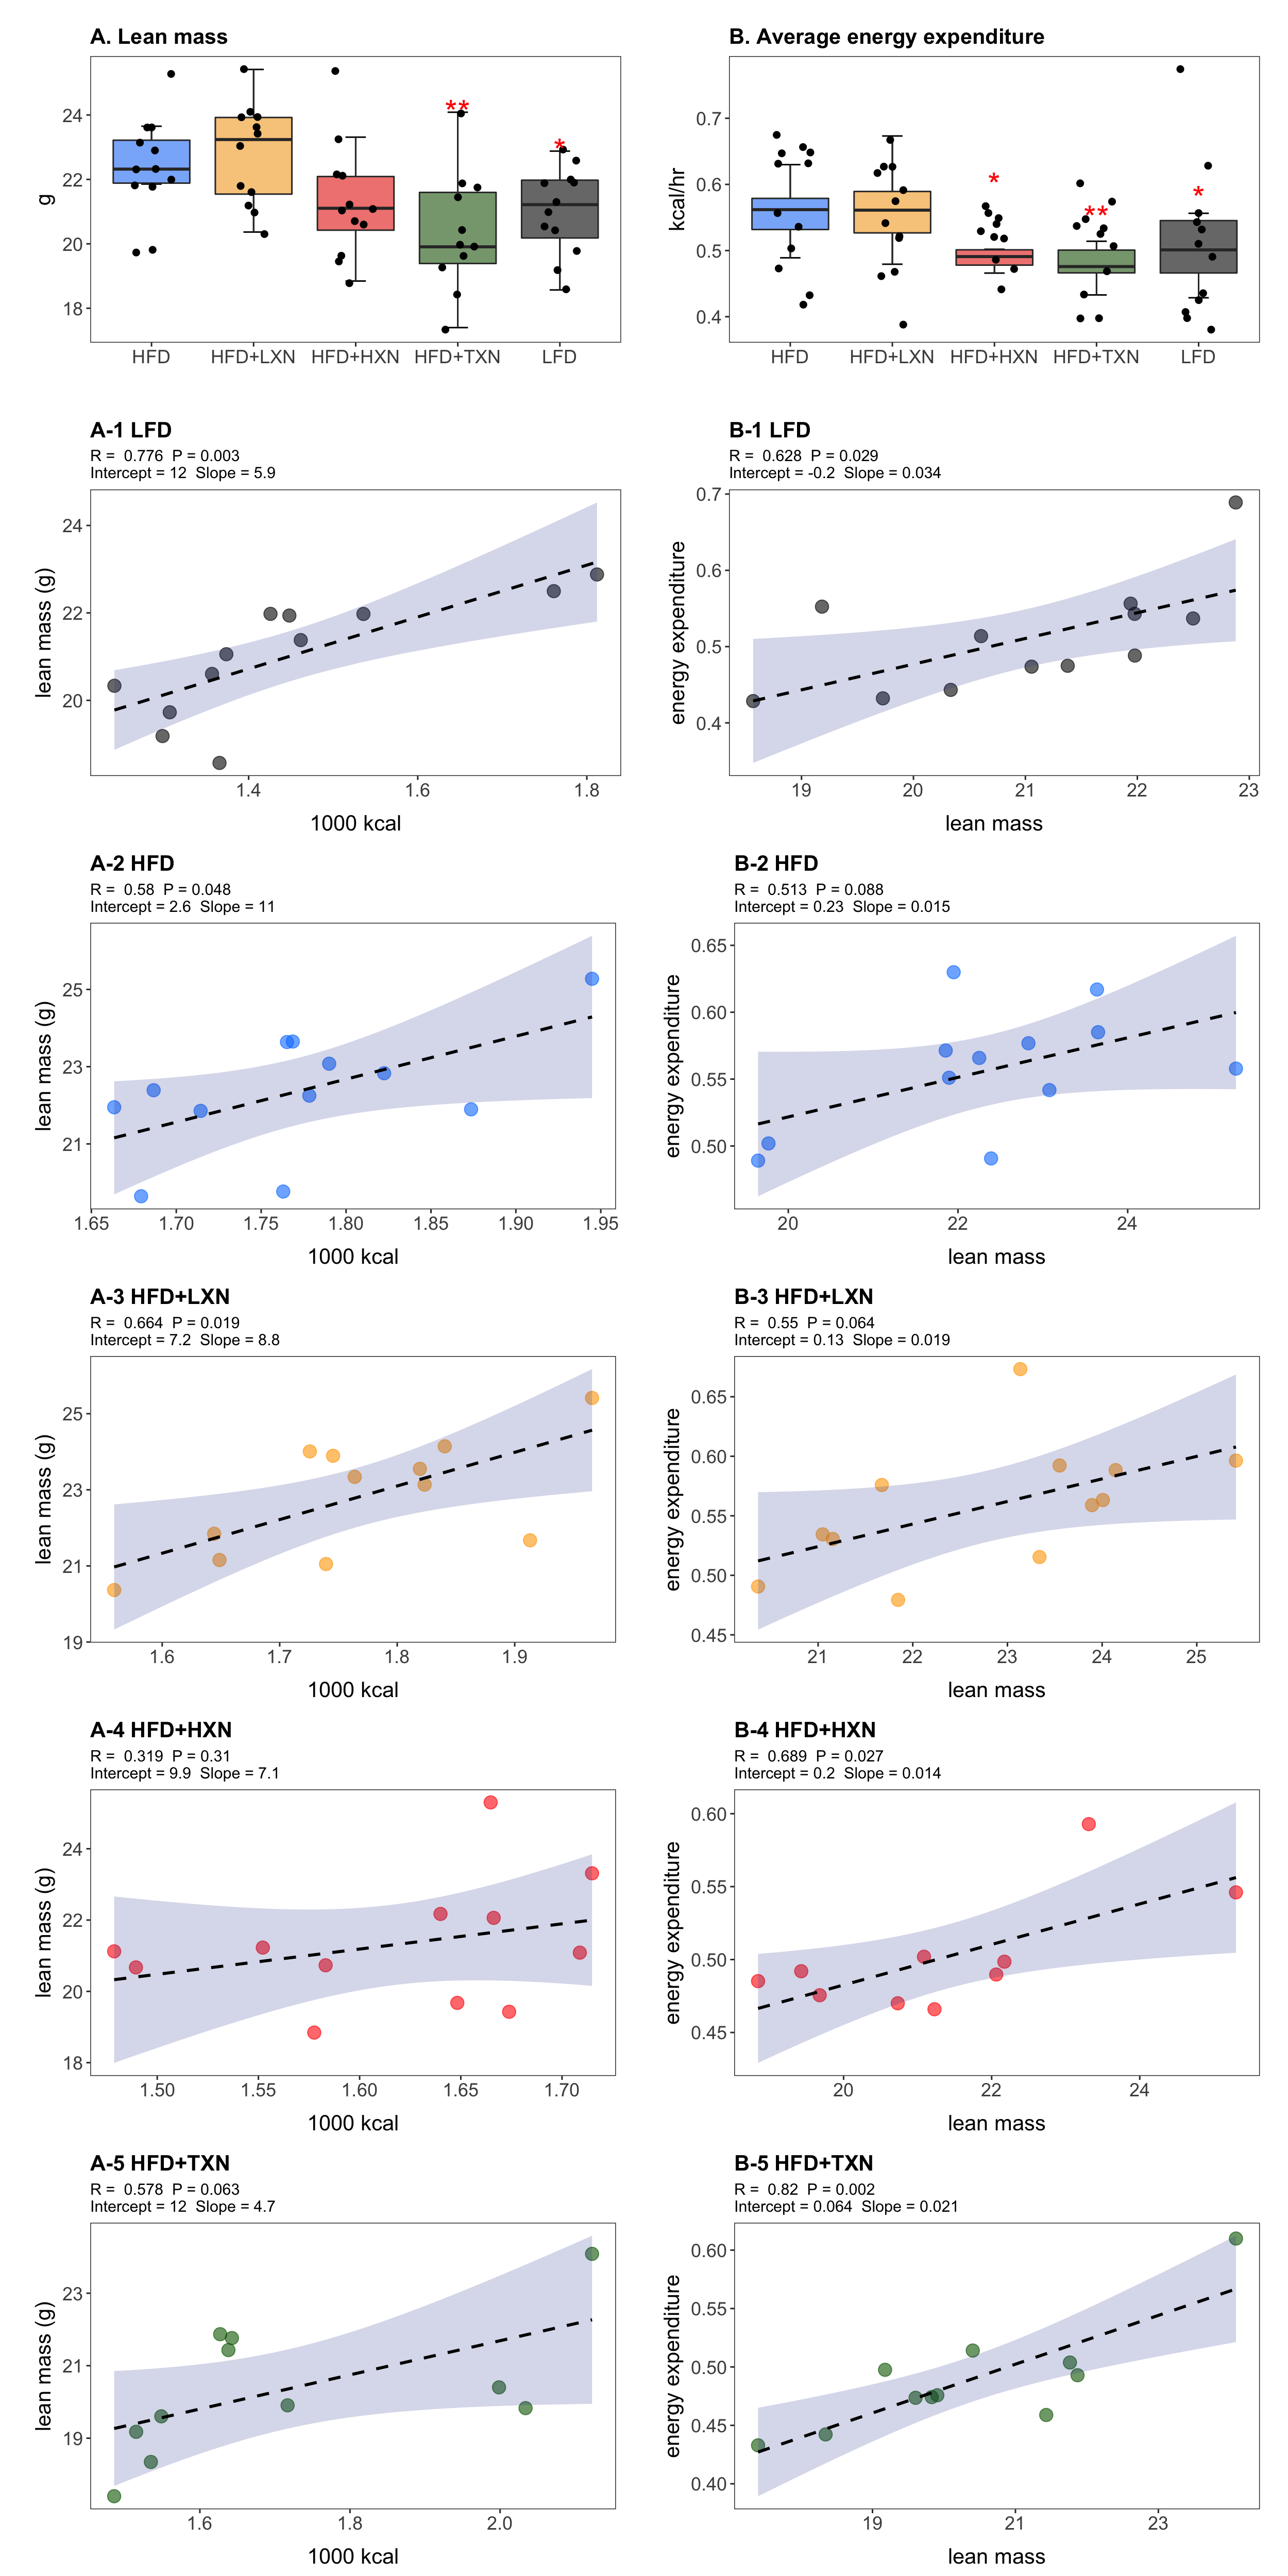

In [93]:
options(repr.plot.width = 12.5, repr.plot.height = 25, repr.plot.res = 200)
(figure2 <- wrap_plots(row1, row2, row3, row4, row5, row6, nrow=6))

In [97]:
graph2pdf(figure2, "figure2-extra.pdf", width = 12.5, height = 25)

Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

Exported graph as figure2-extra.pdf



In [12]:
.ci <-
function(x,conf.level=0.95) {
  tri <- sort(na.omit(x))
  if (any(!is.finite(tri))) {tri <- tri[-which(!is.finite(tri))]}
  repet <- length(tri)
  int <- (1-conf.level)/2
  if(repet*int<1) {
    int.inf <- ceiling(repet*int)
  } else {
    int.inf <- floor(repet*int)
  }
  int.sup <- ceiling(repet*(1-int))
  result <- c("Inf"=tri[int.inf],"Sup"=tri[int.sup])
  return(result)
}

spearman.ci <-
function(var1,var2,nrep=1000,conf.level=0.95){
  if (length(var1)!=length(var2)) {stop(paste("'",deparse(substitute(var1)),"' and '",
    deparse(substitute(var2)),"' lengths differ",sep=""))}
  data.name <- paste(deparse(substitute(var1))," and ",deparse(substitute(var2)),"\n",nrep," replicates",sep="")
  nul <- as.numeric(row.names(table(c(which(is.na(var1)),which(is.na(var2))))))
  var1.2 <- if(length(nul)>0) {var1[-nul]} else {var1}
  var2.2 <- if(length(nul)>0) {var2[-nul]} else {var2}
  cor.fun <- function(data,ind) {
    as.numeric(suppressWarnings(cor.test(data[ind,1],data[ind,2],method="spearman")$estimate))
  }
  simul <- boot::boot(data.frame(var1.2,var2.2),cor.fun,R=nrep)
  interval <- .ci(simul$t,conf.level=conf.level)
  attr(interval,"conf.level") <- conf.level
  coeff <- as.numeric(suppressWarnings(cor.test(var1,var2,method="spearman")$estimate))
  names(coeff) <- "rho"
  result <- list(method="Spearman's rank correlation",conf.level=conf.level,rep=nrep,data.name=data.name,
    estimate=coeff,conf.int=interval)
  class(result) <- "htest"
  return(result)
}

pearson.ci <-
function(var1,var2,nrep=1000,conf.level=0.95){
  if (length(var1)!=length(var2)) {stop(paste("'",deparse(substitute(var1)),"' and '",
    deparse(substitute(var2)),"' lengths differ",sep=""))}
  data.name <- paste(deparse(substitute(var1))," and ",deparse(substitute(var2)),"\n",nrep," replicates",sep="")
  nul <- as.numeric(row.names(table(c(which(is.na(var1)),which(is.na(var2))))))
  var1.2 <- if(length(nul)>0) {var1[-nul]} else {var1}
  var2.2 <- if(length(nul)>0) {var2[-nul]} else {var2}
  cor.fun <- function(data,ind) {
    as.numeric(suppressWarnings(cor.test(data[ind,1],data[ind,2],method="pearson")$estimate))
  }
  simul <- boot::boot(data.frame(var1.2,var2.2),cor.fun,R=nrep)
  interval <- .ci(simul$t,conf.level=conf.level)
  attr(interval,"conf.level") <- conf.level
  coeff <- as.numeric(suppressWarnings(cor.test(var1,var2,method="pearson")$estimate))
  names(coeff) <- "rho"
  result <- list(method="pearson correlation",conf.level=conf.level,rep=nrep,data.name=data.name,
    estimate=coeff,conf.int=interval)
  class(result) <- "htest"
  return(result)
}

In [13]:
names(data)

[1] "ID"                 "Treatment"          "Cal_cum"           
 [4] "LV_TAG"             "lipidosis_area_pct" "Fat_mass"          
 [7] "subq_wt"            "epi_wat"            "mesenteric_wt"     
[10] "plasma_TAG"         "liver_wt"           "TG_feces"          
[13] "TG_feces2"          "fecal_tot_output"   "wt"                
[16] "Lean_mass"          "Lean_mass_outlier"  "avgEE"             
[19] "avgEE2"             "leptin_new"         "glucose_plasma"    
[22] "insulin_plasma"     "CHL_feces2"         "uptake_freq_light" 
[25] "uptake_freq_dark"   "allmeters_light"    "allmeters_dark"    
[28] "pedmeters_light"    "pedmeters_dark"     "bw_cage"           
[31] "vars"               "vars2"              "lv_tot_tag"        
[34] "EE_norm"            "fecal_tot_tag"      "kkcal"             
[37] "uptake_f"           "allMeters"          "allPeds"

In [15]:
data_hfd <- data %>% filter(Treatment == "HFD")

In [19]:
(data_hfd)

ID,Treatment,Cal_cum,LV_TAG,lipidosis_area_pct,Fat_mass,subq_wt,epi_wat,mesenteric_wt,plasma_TAG,⋯,bw_cage,vars,vars2,lv_tot_tag,EE_norm,fecal_tot_tag,kkcal,uptake_f,allMeters,allPeds
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
13,HFD,1686.673,500.76,11.683,18.670,1.89,2.49,1.57,43.762,⋯,37.4,HFD,HFD,1.1317176,21.91539,17.7255,1.686673,32,207.1770,152.11413
14,HFD,1944.873,480.48,27.536,18.154,2.00,2.11,1.23,59.346,⋯,47.2,HFD,HFD,1.2060048,22.07031,27.9942,1.944873,32,192.2072,142.91714
15,HFD,1663.419,633.36,21.128,20.911,2.65,1.73,1.25,38.095,⋯,47.2,HFD,HFD,1.7797416,28.69857,15.2490,1.663419,20,113.4093,70.01475
16,HFD,1765.193,535.08,18.855,21.292,2.49,2.64,1.60,54.041,⋯,44.6,HFD,HFD,1.4447160,26.10114,25.9038,1.765193,21,137.3111,111.76440
17,HFD,1679.297,402.87,10.571,18.396,2.08,3.36,1.03,51.388,⋯,38.0,HFD,HFD,0.5881902,24.89506,17.0820,1.679297,26,146.4084,114.01472
18,HFD,1790.035,563.94,12.115,20.473,2.53,1.85,1.83,41.923,⋯,47.0,HFD,HFD,1.5621138,23.47750,10.2765,1.790035,38,189.2754,144.95574
19,HFD,1873.626,627.51,18.259,17.885,1.91,2.03,1.24,44.998,⋯,44.1,HFD,HFD,1.4181726,25.16649,10.9395,1.873626,28,171.4451,141.20477
20,HFD,1822.406,615.81,19.598,19.700,2.96,1.61,1.43,38.427,⋯,48.6,HFD,HFD,1.6565289,25.26549,9.6135,1.822406,34,156.4770,96.95221
21,HFD,1768.625,900.12,13.914,21.159,2.43,1.61,1.32,38.367,⋯,51.0,HFD,HFD,2.8983864,24.73699,9.5511,1.768625,24,171.2141,125.76162


In [16]:
data_hfd %>%
    summarise(r = pearson.ci(avgEE2, bw_cage)$estimate,
             pvalue = cor.test(avgEE2, bw_cage, method = "pearson")$p.value,
             lower = pearson.ci(avgEE2, bw_cage)$conf.int[1],
             upper = pearson.ci(avgEE2, bw_cage)$conf.int[2])

r,pvalue,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
0.6368393,0.02595045,-0.0261103,0.9335341


In [17]:
data_hfd %>%
    summarise(r = spearman.ci(avgEE2, bw_cage)$estimate,
             pvalue = cor.test(avgEE2, bw_cage, method = "spearman")$p.value,
             lower = spearman.ci(avgEE2, bw_cage)$conf.int[1],
             upper = spearman.ci(avgEE2, bw_cage)$conf.int[2])

Warning message in cor.test.default(avgEE2, bw_cage, method = "spearman"):
“Cannot compute exact p-value with ties”


r,pvalue,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
0.6164633,0.03277604,0.02857143,0.9352518


In [125]:
data %>%
    summarise(r = pearson.ci(kkcal, Lean_mass)$estimate,
             pvalue = cor.test(kkcal, Lean_mass, method = "pearson")$p.value,
             lower = pearson.ci(kkcal, Lean_mass)$conf.int[1],
             upper = pearson.ci(kkcal, Lean_mass)$conf.int[2])

r,pvalue,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
0.5378994,1.115028e-05,0.3243288,0.7032177


In [126]:
data %>%
    summarise(r = spearman.ci(kkcal, Lean_mass)$estimate,
             pvalue = cor.test(kkcal, Lean_mass, method = "spearman")$p.value,
             lower = spearman.ci(kkcal, Lean_mass)$conf.int[1],
             upper = spearman.ci(kkcal, Lean_mass)$conf.int[2])

r,pvalue,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
0.5773232,2.69267e-06,0.3426189,0.7494144


In [103]:
dataHFD <- data %>%
filter(Treatment == "HFD")
dataTXN <- data %>%
filter(Treatment == "HFD+TXN")
dataHXN <- data %>%
filter(Treatment == "HFD+HXN")
dataLXN <- data %>%
filter(Treatment == "HFD+LXN")
dataLFD <- data %>%
filter(Treatment == "LFD")

In [106]:
dataLFD %>%
    summarise(r = pearson.ci(avgEE2, Lean_mass)$estimate,
             pvalue = cor.test(avgEE2, Lean_mass, method = "pearson")$p.value,
             lower = pearson.ci(avgEE2, Lean_mass)$conf.int[1],
             upper = pearson.ci(avgEE2, Lean_mass)$conf.int[2])

r,pvalue,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
0.6280258,0.0287623,0.002135208,0.8987219


In [107]:
dataLFD %>%
    summarise(r = spearman.ci(avgEE2, Lean_mass)$estimate,
             pvalue = cor.test(avgEE2, Lean_mass, method = "spearman")$p.value,
             lower = spearman.ci(avgEE2, Lean_mass)$conf.int[1],
             upper = spearman.ci(avgEE2, Lean_mass)$conf.int[2])

r,pvalue,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
0.6083916,0.04000205,-0.0610687,0.9782609


In [127]:
dataLFD %>%
    summarise(r = pearson.ci(kkcal, Lean_mass)$estimate,
             pvalue = cor.test(kkcal, Lean_mass, method = "pearson")$p.value,
             lower = pearson.ci(kkcal, Lean_mass)$conf.int[1],
             upper = pearson.ci(kkcal, Lean_mass)$conf.int[2])

r,pvalue,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
0.7758628,0.003015098,0.6187175,0.9280182


In [128]:
dataLFD %>%
    summarise(r = spearman.ci(kkcal, Lean_mass)$estimate,
             pvalue = cor.test(kkcal, Lean_mass, method = "spearman")$p.value,
             lower = spearman.ci(kkcal, Lean_mass)$conf.int[1],
             upper = spearman.ci(kkcal, Lean_mass)$conf.int[2])

r,pvalue,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
0.8601399,0.0005970843,0.5428571,0.9924812


In [104]:
dataHFD %>%
    summarise(r = pearson.ci(avgEE2, Lean_mass)$estimate,
             pvalue = cor.test(avgEE2, Lean_mass, method = "pearson")$p.value,
             lower = pearson.ci(avgEE2, Lean_mass)$conf.int[1],
             upper = pearson.ci(avgEE2, Lean_mass)$conf.int[2])

r,pvalue,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
0.5130795,0.08802227,-0.1516032,0.8878329


In [108]:
dataHFD %>%
    summarise(r = spearman.ci(avgEE2, Lean_mass)$estimate,
             pvalue = cor.test(avgEE2, Lean_mass, method = "spearman")$p.value,
             lower = spearman.ci(avgEE2, Lean_mass)$conf.int[1],
             upper = spearman.ci(avgEE2, Lean_mass)$conf.int[2])

r,pvalue,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
0.4195804,0.176577,-0.1612903,0.8723404


In [129]:
dataHFD %>%
    summarise(r = pearson.ci(kkcal, Lean_mass)$estimate,
             pvalue = cor.test(kkcal, Lean_mass, method = "pearson")$p.value,
             lower = pearson.ci(kkcal, Lean_mass)$conf.int[1],
             upper = pearson.ci(kkcal, Lean_mass)$conf.int[2])

r,pvalue,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
0.5802809,0.04792199,0.0003801945,0.8699313


In [130]:
dataHFD %>%
    summarise(r = spearman.ci(kkcal, Lean_mass)$estimate,
             pvalue = cor.test(kkcal, Lean_mass, method = "spearman")$p.value,
             lower = spearman.ci(kkcal, Lean_mass)$conf.int[1],
             upper = spearman.ci(kkcal, Lean_mass)$conf.int[2])

r,pvalue,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
0.5384615,0.07490229,-0.1217712,0.8709677


In [105]:
dataTXN %>%
    summarise(r = pearson.ci(avgEE2, Lean_mass)$estimate,
             pvalue = cor.test(avgEE2, Lean_mass, method = "pearson")$p.value,
             lower = pearson.ci(avgEE2, Lean_mass)$conf.int[1],
             upper = pearson.ci(avgEE2, Lean_mass)$conf.int[2])

r,pvalue,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
0.8196916,0.002011083,0.116154,0.9748749


In [109]:
dataTXN %>%
    summarise(r = spearman.ci(avgEE2, Lean_mass)$estimate,
             pvalue = cor.test(avgEE2, Lean_mass, method = "spearman")$p.value,
             lower = spearman.ci(avgEE2, Lean_mass)$conf.int[1],
             upper = spearman.ci(avgEE2, Lean_mass)$conf.int[2])

r,pvalue,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
0.6909091,0.02305887,0.1028037,0.9723502


In [131]:
dataTXN %>%
    summarise(r = pearson.ci(kkcal, Lean_mass)$estimate,
             pvalue = cor.test(kkcal, Lean_mass, method = "pearson")$p.value,
             lower = pearson.ci(kkcal, Lean_mass)$conf.int[1],
             upper = pearson.ci(kkcal, Lean_mass)$conf.int[2])

r,pvalue,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
0.5776347,0.06274242,0.02144556,0.8941444


In [132]:
dataTXN %>%
    summarise(r = spearman.ci(kkcal, Lean_mass)$estimate,
             pvalue = cor.test(kkcal, Lean_mass, method = "spearman")$p.value,
             lower = spearman.ci(kkcal, Lean_mass)$conf.int[1],
             upper = spearman.ci(kkcal, Lean_mass)$conf.int[2])

r,pvalue,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
0.6909091,0.02305887,-0.03349282,0.9626168


In [112]:
dataHXN %>%
    summarise(r = pearson.ci(avgEE2, Lean_mass)$estimate,
             pvalue = cor.test(avgEE2, Lean_mass, method = "pearson")$p.value,
             lower = pearson.ci(avgEE2, Lean_mass)$conf.int[1],
             upper = pearson.ci(avgEE2, Lean_mass)$conf.int[2])

r,pvalue,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
0.6891619,0.02749367,0.1480046,0.9149724


In [110]:
dataHXN %>%
    summarise(r = spearman.ci(avgEE2, Lean_mass)$estimate,
             pvalue = cor.test(avgEE2, Lean_mass, method = "spearman")$p.value,
             lower = spearman.ci(avgEE2, Lean_mass)$conf.int[1],
             upper = spearman.ci(avgEE2, Lean_mass)$conf.int[2])

r,pvalue,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
0.5757576,0.08776804,-0.2075472,0.8867925


In [133]:
dataHXN %>%
    summarise(r = pearson.ci(kkcal, Lean_mass)$estimate,
             pvalue = cor.test(kkcal, Lean_mass, method = "pearson")$p.value,
             lower = pearson.ci(kkcal, Lean_mass)$conf.int[1],
             upper = pearson.ci(kkcal, Lean_mass)$conf.int[2])

r,pvalue,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
0.3190634,0.3120827,-0.1414687,0.6574148


In [134]:
dataHXN %>%
    summarise(r = spearman.ci(kkcal, Lean_mass)$estimate,
             pvalue = cor.test(kkcal, Lean_mass, method = "spearman")$p.value,
             lower = spearman.ci(kkcal, Lean_mass)$conf.int[1],
             upper = spearman.ci(kkcal, Lean_mass)$conf.int[2])

r,pvalue,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
0.2587413,0.4169384,-0.3430657,0.734767


In [113]:
dataLXN %>%
    summarise(r = pearson.ci(avgEE2, Lean_mass)$estimate,
             pvalue = cor.test(avgEE2, Lean_mass, method = "pearson")$p.value,
             lower = pearson.ci(avgEE2, Lean_mass)$conf.int[1],
             upper = pearson.ci(avgEE2, Lean_mass)$conf.int[2])

r,pvalue,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
0.5499691,0.06394413,0.2342754,0.8421622


In [111]:
dataLXN %>%
    summarise(r = spearman.ci(avgEE2, Lean_mass)$estimate,
             pvalue = cor.test(avgEE2, Lean_mass, method = "spearman")$p.value,
             lower = spearman.ci(avgEE2, Lean_mass)$conf.int[1],
             upper = spearman.ci(avgEE2, Lean_mass)$conf.int[2])

r,pvalue,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
0.5734266,0.05548132,0.05882353,0.887218


In [135]:
dataLXN %>%
    summarise(r = pearson.ci(kkcal, Lean_mass)$estimate,
             pvalue = cor.test(kkcal, Lean_mass, method = "pearson")$p.value,
             lower = pearson.ci(kkcal, Lean_mass)$conf.int[1],
             upper = pearson.ci(kkcal, Lean_mass)$conf.int[2])

r,pvalue,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
0.663725,0.01859954,0.05015521,0.9523484


In [136]:
dataLXN %>%
    summarise(r = spearman.ci(kkcal, Lean_mass)$estimate,
             pvalue = cor.test(kkcal, Lean_mass, method = "spearman")$p.value,
             lower = spearman.ci(kkcal, Lean_mass)$conf.int[1],
             upper = spearman.ci(kkcal, Lean_mass)$conf.int[2])

r,pvalue,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
0.5734266,0.05548132,-0.1366906,0.9191176


In [62]:
names(data)

[1] "ID"                 "Treatment"          "Cal_cum"           
 [4] "LV_TAG"             "lipidosis_area_pct" "Fat_mass"          
 [7] "subq_wt"            "epi_wat"            "mesenteric_wt"     
[10] "plasma_TAG"         "liver_wt"           "TG_feces"          
[13] "TG_feces2"          "fecal_tot_output"   "wt"                
[16] "Lean_mass"          "Lean_mass_outlier"  "avgEE"             
[19] "avgEE2"             "leptin_new"         "glucose_plasma"    
[22] "insulin_plasma"     "CHL_feces2"         "uptake_freq_light" 
[25] "uptake_freq_dark"   "allmeters_light"    "allmeters_dark"    
[28] "pedmeters_light"    "pedmeters_dark"     "bw_cage"           
[31] "vars"               "vars2"              "lv_tot_tag"        
[34] "EE_norm"            "fecal_tot_tag"      "kkcal"             
[37] "uptake_f"           "allMeters"          "allPeds"

In [66]:
data %>% group_by(Treatment) %>%
summarize(mean = mean(Fat_mass), n = n(),
         sd = sd(Fat_mass), se = sd/sqrt(n))

`summarise()` ungrouping output (override with `.groups` argument)



Treatment,mean,n,sd,se
<chr>,<dbl>,<int>,<dbl>,<dbl>
HFD,19.86983,12,1.258807,0.3633863
HFD+HXN,17.89692,12,2.258926,0.6520956
HFD+LXN,19.27225,12,2.316036,0.6685820
HFD+TXN,14.35636,11,3.419456,1.0310047
LFD,10.41842,12,2.179558,0.6291841


In [64]:
(19.86983-17.89692)*100/19.86983

[1] 9.929174

In [65]:
(19.86983-14.35636)*100/19.86983

[1] 27.74795